# Итоговый проект по работе с временными рядами

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor
timedata = pd.read_csv('timedata/train.csv') # считываем датасет
df = timedata.copy()
df.head() # смотрим на первые несколько строчек

C:\Users\Алексей\AppData\Local\Temp\ipykernel_6072\2494926580.py:11: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  timedata = pd.read_csv('timedata/train.csv') # считываем датасет


id        date  store_nbr  item_nbr  unit_sales onpromotion
0   0  2013-01-01         25    103665         7.0         NaN
1   1  2013-01-01         25    105574         1.0         NaN
2   2  2013-01-01         25    105575         2.0         NaN
3   3  2013-01-01         25    108079         1.0         NaN
4   4  2013-01-01         25    108701         1.0         NaN

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   item_nbr     int64  
 4   unit_sales   float64
 5   onpromotion  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 5.6+ GB


In [3]:
df1 = df[df.store_nbr==25].groupby("date")['unit_sales'].sum().reset_index()
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1618 entries, 0 to 1617
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1618 non-null   object 
 1   unit_sales  1618 non-null   float64
dtypes: float64(1), object(1)
memory usage: 25.4+ KB


In [4]:
# приводим индексы к стандарту pd.Datetime, чтобы потом это можно было скормить seasonal_decompose
df1.rename(columns = {'date':'Month'}, inplace = True)
new_df = df1.set_index(pd.DatetimeIndex(df1['Month'])) 
new_df.head() # смотрим на результат

Month  unit_sales
Month                             
2013-01-01  2013-01-01    2511.619
2013-01-02  2013-01-02    5316.224
2013-01-03  2013-01-03    4442.913
2013-01-04  2013-01-04    4844.354
2013-01-05  2013-01-05    5817.526

In [5]:
 # замечаем, что т.к. у нас теперь есть индекс Month, нам больше не нужен столбец Month, который его дублирует
new_df.drop(['Month'], axis = 1, inplace = True)
new_df.head() # снова проверяем, что все в порядке. вообще проверять данные на каждом шаге кода - хорошая привычка

unit_sales
Month                 
2013-01-01    2511.619
2013-01-02    5316.224
2013-01-03    4442.913
2013-01-04    4844.354
2013-01-05    5817.526

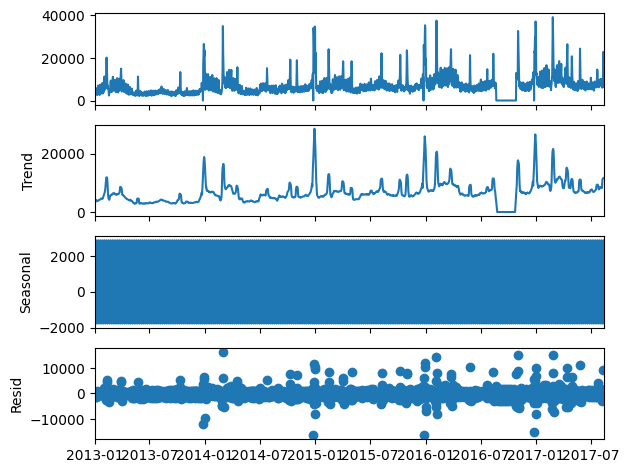

In [6]:
# применяем seasonal_decompose
# эта функция разложит ряд на трендовую, сезонную и шумовую составляющие
decomposition = seasonal_decompose(new_df.asfreq('d').fillna(0), model='additive') 
decomposition.plot()
pyplot.show() # любуемся результатом

In [7]:
trend_part = decomposition.trend # отдельно трендовая составляющаяя
seasonal_part = decomposition.seasonal # отдельно сезонная составляющаяя
residual_part = decomposition.resid # отдельно шум: то, что осталось

In [8]:
trend_part.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1688 entries, 2013-01-01 to 2017-08-15
Freq: D
Series name: trend
Non-Null Count  Dtype  
--------------  -----  
1682 non-null   float64
dtypes: float64(1)
memory usage: 26.4 KB


In [9]:
seasonal_part.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1688 entries, 2013-01-01 to 2017-08-15
Freq: D
Series name: seasonal
Non-Null Count  Dtype  
--------------  -----  
1688 non-null   float64
dtypes: float64(1)
memory usage: 26.4 KB


In [10]:
residual_part.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1688 entries, 2013-01-01 to 2017-08-15
Freq: D
Series name: resid
Non-Null Count  Dtype  
--------------  -----  
1682 non-null   float64
dtypes: float64(1)
memory usage: 26.4 KB


In [11]:
residual_part = residual_part.dropna()
residual_part.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1682 entries, 2013-01-04 to 2017-08-12
Freq: D
Series name: resid
Non-Null Count  Dtype  
--------------  -----  
1682 non-null   float64
dtypes: float64(1)
memory usage: 26.3 KB


In [12]:
#Выполним тест Дики-Фулера для проверки стационарности временного ряда
from statsmodels.tsa.stattools import adfuller

test = adfuller(new_df['unit_sales'])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: # проверка, больше ли критического полученное значение для нашего ряда 
    print ('ряд не стационарен')
else:
    print ('ряд стационарен')

adf:  -4.858992665318179
p-value:  4.188394192907804e-05
Critical values:  {'1%': -3.4344642432857992, '5%': -2.8633571955690647, '10%': -2.5677374399794197}
ряд стационарен


In [13]:
#Разбиение и вывод размеров полученных подвыборок временного ряда
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3, test_size=7)
train_test_groups = tscv.split(df.unit_sales) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 125497019 TEST size: 7
TRAIN size: 125497026 TEST size: 7
TRAIN size: 125497033 TEST size: 7


In [14]:
new_df['rolling_mean'] = new_df.unit_sales.rolling(window=5).mean()#скользящее среднее
new_df

unit_sales  rolling_mean
Month                               
2013-01-01    2511.619           NaN
2013-01-02    5316.224           NaN
2013-01-03    4442.913           NaN
2013-01-04    4844.354           NaN
2013-01-05    5817.526     4586.5272
...                ...           ...
2017-08-11   22800.841    11368.5020
2017-08-12   15090.753    12881.1830
2017-08-13    8570.598    13390.2968
2017-08-14    8244.854    13097.6960
2017-08-15    6522.788    12245.9668

[1618 rows x 2 columns]

In [15]:
new_df['rolling_std'] = new_df.unit_sales.rolling(window=5).std()#скользящее стандартное отклонение
new_df

unit_sales  rolling_mean  rolling_std
Month                                            
2013-01-01    2511.619           NaN          NaN
2013-01-02    5316.224           NaN          NaN
2013-01-03    4442.913           NaN          NaN
2013-01-04    4844.354           NaN          NaN
2013-01-05    5817.526     4586.5272  1268.873437
...                ...           ...          ...
2017-08-11   22800.841    11368.5020  6654.095169
2017-08-12   15090.753    12881.1830  6418.091607
2017-08-13    8570.598    13390.2968  5810.462774
2017-08-14    8244.854    13097.6960  6073.159403
2017-08-15    6522.788    12245.9668  6741.108828

[1618 rows x 3 columns]

In [16]:
new_df1 = new_df.copy()
#Построим линии Болинджера
new_df1['upperbollinger'] = new_df1.unit_sales.rolling(30).mean() + 3 * new_df1.unit_sales.rolling(30).std()
new_df1['lowerbollinger'] = new_df1.unit_sales.rolling(30).mean() - 3 * new_df1.unit_sales.rolling(30).std()
new_df1.head(35)

unit_sales  rolling_mean  rolling_std  upperbollinger   
Month                                                               
2013-01-01    2511.619           NaN          NaN             NaN  \
2013-01-02    5316.224           NaN          NaN             NaN   
2013-01-03    4442.913           NaN          NaN             NaN   
2013-01-04    4844.354           NaN          NaN             NaN   
2013-01-05    5817.526     4586.5272  1268.873437             NaN   
2013-01-06    3201.695     4724.5424   994.665070             NaN   
2013-01-07    2783.978     4218.0932  1233.965510             NaN   
2013-01-08    2884.284     3906.3674  1354.005326             NaN   
2013-01-09    3565.639     3650.6244  1249.257405             NaN   
2013-01-10    2673.934     3021.9060   362.147663             NaN   
2013-01-11    4794.148     3340.3966   884.016407             NaN   
2013-01-12    7036.223     4190.8456  1792.983104             NaN   
2013-01-13    3174.204     4248.8296  1744.190346             NaN   
2013-01-14    3156.056     4166.9130  1793.227046             NaN   
2013-01-15    3005.576     4233.2414  1729.188610             NaN   
2013-01-16    3854.700     4045.3518  1703.858699             NaN   
2013-01-17    2616.904     3161.4880   447.664597             NaN   
2013-01-18    5695.546     3665.7564  1219.781694             NaN   
2013-01-19    7456.022     4525.7496  2022.365374             NaN   
2013-01-20    3495.272     4623.6888  1940.543912             NaN   
2013-01-21    3768.027     4606.3542  1949.496960             NaN   
2013-01-22    3270.978     4737.1690  1798.743209             NaN   
2013-01-23    4528.585     4503.7768  1717.161156             NaN   
2013-01-24    3562.141     3725.0006   482.968467             NaN   
2013-01-25    5698.591     4165.6644   975.242928             NaN   
2013-01-26    8207.192     5053.4974  2002.435251             NaN   
2013-01-27    3442.038     5087.7094  1965.487307             NaN   
2013-01-28    3278.216     4837.6356  2127.294241             NaN   
2013-01-29    3554.633     4836.1340  2128.422014             NaN   
2013-01-30    4302.477     4556.9112  2077.970882     8664.991493   
2013-01-31    4252.359     3765.9446   477.470745     8619.625561   
2013-02-01    8838.678     4845.2726  2275.679967     9381.562618   
2013-02-02   11254.187     6440.4668  3413.582135    10868.899812   
2013-02-03    4976.038     6724.7478  3163.171214    10875.293916   
2013-02-04    5595.269     6983.3062  2962.122247    10855.715624   

            lowerbollinger  
Month                       
2013-01-01             NaN  
2013-01-02             NaN  
2013-01-03             NaN  
2013-01-04             NaN  
2013-01-05             NaN  
2013-01-06             NaN  
2013-01-07             NaN  
2013-01-08             NaN  
2013-01-09             NaN  
2013-01-10             NaN  
2013-01-11             NaN  
2013-01-12             NaN  
2013-01-13             NaN  
2013-01-14             NaN  
2013-01-15             NaN  
2013-01-16             NaN  
2013-01-17             NaN  
2013-01-18             NaN  
2013-01-19             NaN  
2013-01-20             NaN  
2013-01-21             NaN  
2013-01-22             NaN  
2013-01-23             NaN  
2013-01-24             NaN  
2013-01-25             NaN  
2013-01-26             NaN  
2013-01-27             NaN  
2013-01-28             NaN  
2013-01-29             NaN  
2013-01-30     -269.011827  
2013-01-31     -107.596561  
2013-02-01     -634.703351  
2013-02-02    -1667.955612  
2013-02-03    -1665.570783  
2013-02-04    -1660.809624

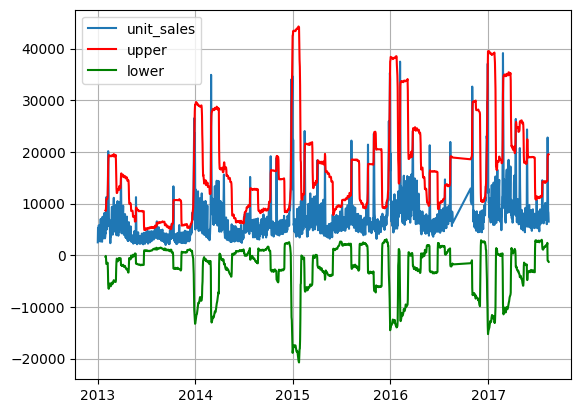

In [17]:
import matplotlib.pyplot as plt 
%matplotlib inline
## визуализируем
plt.plot(new_df1.index, new_df1.unit_sales) ## исходные данные
plt.plot(new_df1.index, new_df1.upperbollinger, c='r') ## верхняя линия Боллинджера
plt.plot(new_df1.index, new_df1.lowerbollinger,  c='g') ## Нижняя линия Болинджера
plt.legend(['unit_sales', 'upper', 'lower'])
plt.grid()


plt.show()

In [18]:
new_df1['rolling_mean_new'] = new_df1.unit_sales.rolling(window=10).mean()#скользящее среднее в 10 точек
new_df1

unit_sales  rolling_mean  rolling_std  upperbollinger   
Month                                                               
2013-01-01    2511.619           NaN          NaN             NaN  \
2013-01-02    5316.224           NaN          NaN             NaN   
2013-01-03    4442.913           NaN          NaN             NaN   
2013-01-04    4844.354           NaN          NaN             NaN   
2013-01-05    5817.526     4586.5272  1268.873437             NaN   
...                ...           ...          ...             ...   
2017-08-11   22800.841    11368.5020  6654.095169    18795.452399   
2017-08-12   15090.753    12881.1830  6418.091607    19510.723564   
2017-08-13    8570.598    13390.2968  5810.462774    19504.431175   
2017-08-14    8244.854    13097.6960  6073.159403    19496.994710   
2017-08-15    6522.788    12245.9668  6741.108828    19531.676616   

            lowerbollinger  rolling_mean_new  
Month                                         
2013-01-01             NaN               NaN  
2013-01-02             NaN               NaN  
2013-01-03             NaN               NaN  
2013-01-04             NaN               NaN  
2013-01-05             NaN               NaN  
...                    ...               ...  
2017-08-11     -980.395399        10110.3653  
2017-08-12    -1086.376164        10605.8079  
2017-08-13    -1102.017641        10775.4875  
2017-08-14    -1131.959510        10672.2839  
2017-08-15    -1263.082216        10333.5612  

[1618 rows x 6 columns]

In [19]:
new_df1['exp_mean'] = new_df1.unit_sales.ewm(span=7).mean()#экспоненциальное среднее
new_df1

unit_sales  rolling_mean  rolling_std  upperbollinger   
Month                                                               
2013-01-01    2511.619           NaN          NaN             NaN  \
2013-01-02    5316.224           NaN          NaN             NaN   
2013-01-03    4442.913           NaN          NaN             NaN   
2013-01-04    4844.354           NaN          NaN             NaN   
2013-01-05    5817.526     4586.5272  1268.873437             NaN   
...                ...           ...          ...             ...   
2017-08-11   22800.841    11368.5020  6654.095169    18795.452399   
2017-08-12   15090.753    12881.1830  6418.091607    19510.723564   
2017-08-13    8570.598    13390.2968  5810.462774    19504.431175   
2017-08-14    8244.854    13097.6960  6073.159403    19496.994710   
2017-08-15    6522.788    12245.9668  6741.108828    19531.676616   

            lowerbollinger  rolling_mean_new      exp_mean  
Month                                                       
2013-01-01             NaN               NaN   2511.619000  
2013-01-02             NaN               NaN   4114.250429  
2013-01-03             NaN               NaN   4256.374784  
2013-01-04             NaN               NaN   4471.407183  
2013-01-05             NaN               NaN   4912.644593  
...                    ...               ...           ...  
2017-08-11     -980.395399        10110.3653  12367.981578  
2017-08-12    -1086.376164        10605.8079  13048.674434  
2017-08-13    -1102.017641        10775.4875  11929.155325  
2017-08-14    -1131.959510        10672.2839  11008.079994  
2017-08-15    -1263.082216        10333.5612   9886.756995  

[1618 rows x 7 columns]

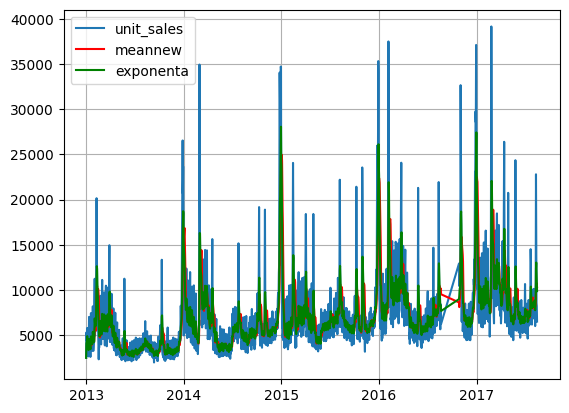

In [20]:
plt.plot(new_df1.index, new_df1.unit_sales) ## исходные данные
plt.plot(new_df1.index, new_df1.rolling_mean_new, c='r') ## оконное среднее 
plt.plot(new_df1.index, new_df1.exp_mean,  c='g') ## оконное экспоненциальное среднее
plt.legend(['unit_sales', 'meannew', 'exponenta'])
plt.grid()


plt.show()

In [21]:
#скользящая функция для нахождения среднего арифметического между мин и макс значениями с окном 10
def window_func(label):
    label = new_df1.unit_sales.rolling(10).mean(new_df1.unit_sales.max() - new_df1.unit_sales.min()) 
    return label
new_df2 = new_df1.copy()
new_df2['new_func'] = window_func(new_df2.unit_sales)

In [22]:
new_df2['rolling_mean_50'] = new_df2.unit_sales.rolling(window=50).mean()
new_df2['exp_mean_10'] = new_df2.unit_sales.ewm(span=10).mean()
new_df2#скользящее среднее с окном 50 и экспоненциальное скользящее среднее с окном 10 


unit_sales  rolling_mean  rolling_std  upperbollinger   
Month                                                               
2013-01-01    2511.619           NaN          NaN             NaN  \
2013-01-02    5316.224           NaN          NaN             NaN   
2013-01-03    4442.913           NaN          NaN             NaN   
2013-01-04    4844.354           NaN          NaN             NaN   
2013-01-05    5817.526     4586.5272  1268.873437             NaN   
...                ...           ...          ...             ...   
2017-08-11   22800.841    11368.5020  6654.095169    18795.452399   
2017-08-12   15090.753    12881.1830  6418.091607    19510.723564   
2017-08-13    8570.598    13390.2968  5810.462774    19504.431175   
2017-08-14    8244.854    13097.6960  6073.159403    19496.994710   
2017-08-15    6522.788    12245.9668  6741.108828    19531.676616   

            lowerbollinger  rolling_mean_new      exp_mean    new_func   
Month                                                                    
2013-01-01             NaN               NaN   2511.619000         NaN  \
2013-01-02             NaN               NaN   4114.250429         NaN   
2013-01-03             NaN               NaN   4256.374784         NaN   
2013-01-04             NaN               NaN   4471.407183         NaN   
2013-01-05             NaN               NaN   4912.644593         NaN   
...                    ...               ...           ...         ...   
2017-08-11     -980.395399        10110.3653  12367.981578  10110.3653   
2017-08-12    -1086.376164        10605.8079  13048.674434  10605.8079   
2017-08-13    -1102.017641        10775.4875  11929.155325  10775.4875   
2017-08-14    -1131.959510        10672.2839  11008.079994  10672.2839   
2017-08-15    -1263.082216        10333.5612   9886.756995  10333.5612   

            rolling_mean_50   exp_mean_10  
Month                                      
2013-01-01              NaN   2511.619000  
2013-01-02              NaN   4054.151750  
2013-01-03              NaN   4210.431189  
2013-01-04              NaN   4419.280511  
2013-01-05              NaN   4820.678762  
...                     ...           ...  
2017-08-11       8208.22576  11294.195768  
2017-08-12       8361.01972  11984.478901  
2017-08-13       8371.36112  11363.773283  
2017-08-14       8390.97734  10796.697050  
2017-08-15       8406.56558  10019.622677  

[1618 rows x 10 columns]

In [23]:
new_df2['sign'] = np.sign(new_df2['rolling_mean_50'] - new_df2['exp_mean_10']).diff()
new_df2

unit_sales  rolling_mean  rolling_std  upperbollinger   
Month                                                               
2013-01-01    2511.619           NaN          NaN             NaN  \
2013-01-02    5316.224           NaN          NaN             NaN   
2013-01-03    4442.913           NaN          NaN             NaN   
2013-01-04    4844.354           NaN          NaN             NaN   
2013-01-05    5817.526     4586.5272  1268.873437             NaN   
...                ...           ...          ...             ...   
2017-08-11   22800.841    11368.5020  6654.095169    18795.452399   
2017-08-12   15090.753    12881.1830  6418.091607    19510.723564   
2017-08-13    8570.598    13390.2968  5810.462774    19504.431175   
2017-08-14    8244.854    13097.6960  6073.159403    19496.994710   
2017-08-15    6522.788    12245.9668  6741.108828    19531.676616   

            lowerbollinger  rolling_mean_new      exp_mean    new_func   
Month                                                                    
2013-01-01             NaN               NaN   2511.619000         NaN  \
2013-01-02             NaN               NaN   4114.250429         NaN   
2013-01-03             NaN               NaN   4256.374784         NaN   
2013-01-04             NaN               NaN   4471.407183         NaN   
2013-01-05             NaN               NaN   4912.644593         NaN   
...                    ...               ...           ...         ...   
2017-08-11     -980.395399        10110.3653  12367.981578  10110.3653   
2017-08-12    -1086.376164        10605.8079  13048.674434  10605.8079   
2017-08-13    -1102.017641        10775.4875  11929.155325  10775.4875   
2017-08-14    -1131.959510        10672.2839  11008.079994  10672.2839   
2017-08-15    -1263.082216        10333.5612   9886.756995  10333.5612   

            rolling_mean_50   exp_mean_10  sign  
Month                                            
2013-01-01              NaN   2511.619000   NaN  
2013-01-02              NaN   4054.151750   NaN  
2013-01-03              NaN   4210.431189   NaN  
2013-01-04              NaN   4419.280511   NaN  
2013-01-05              NaN   4820.678762   NaN  
...                     ...           ...   ...  
2017-08-11       8208.22576  11294.195768   0.0  
2017-08-12       8361.01972  11984.478901   0.0  
2017-08-13       8371.36112  11363.773283   0.0  
2017-08-14       8390.97734  10796.697050   0.0  
2017-08-15       8406.56558  10019.622677   0.0  

[1618 rows x 11 columns]

In [24]:
df2 = new_df2[new_df2['sign'] != 0.0]
df2

unit_sales  rolling_mean  rolling_std  upperbollinger   
Month                                                               
2013-01-01    2511.619           NaN          NaN             NaN  \
2013-01-02    5316.224           NaN          NaN             NaN   
2013-01-03    4442.913           NaN          NaN             NaN   
2013-01-04    4844.354           NaN          NaN             NaN   
2013-01-05    5817.526     4586.5272  1268.873437             NaN   
...                ...           ...          ...             ...   
2017-06-03    9753.867     7606.0048  1903.731211    19048.940759   
2017-06-05    6086.761     7537.8716  1691.113048    19003.086750   
2017-07-02    8452.498     8058.7770  1814.633910    11410.806974   
2017-07-04    5232.484     7907.9514  1972.431278    11042.935013   
2017-07-15    8805.529     7204.0748  1858.836180    11453.662385   

            lowerbollinger  rolling_mean_new     exp_mean    new_func   
Month                                                                   
2013-01-01             NaN               NaN  2511.619000         NaN  \
2013-01-02             NaN               NaN  4114.250429         NaN   
2013-01-03             NaN               NaN  4256.374784         NaN   
2013-01-04             NaN               NaN  4471.407183         NaN   
2013-01-05             NaN               NaN  4912.644593         NaN   
...                    ...               ...          ...         ...   
2017-06-03    -3008.367359        10151.6377  8618.536017  10151.6377   
2017-06-05    -3131.954950         8158.3418  7805.179572   8158.3418   
2017-07-02     2594.122226         7418.7654  7943.149213   7418.7654   
2017-07-04     2631.998320         7114.3335  7131.351183   7114.3335   
2017-07-15     2809.302149         7191.0929  7569.858667   7191.0929   

            rolling_mean_50  exp_mean_10  sign  
Month                                           
2013-01-01              NaN  2511.619000   NaN  
2013-01-02              NaN  4054.151750   NaN  
2013-01-03              NaN  4210.431189   NaN  
2013-01-04              NaN  4419.280511   NaN  
2013-01-05              NaN  4820.678762   NaN  
...                     ...          ...   ...  
2017-06-03       8585.84160  8718.771233  -2.0  
2017-06-05       8375.11050  8082.175552   2.0  
2017-07-02       7557.49456  7655.745634  -2.0  
2017-07-04       7549.72592  7151.488301   2.0  
2017-07-15       7216.29408  7423.255235  -2.0  

[178 rows x 11 columns]

In [25]:
df2.index.unique()#индексы датафрейма, на которых одно скользящее пересекается с другим

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-04-19', '2017-04-29', '2017-05-02', '2017-05-26',
               '2017-05-30', '2017-06-03', '2017-06-05', '2017-07-02',
               '2017-07-04', '2017-07-15'],
              dtype='datetime64[ns]', name='Month', length=178, freq=None)

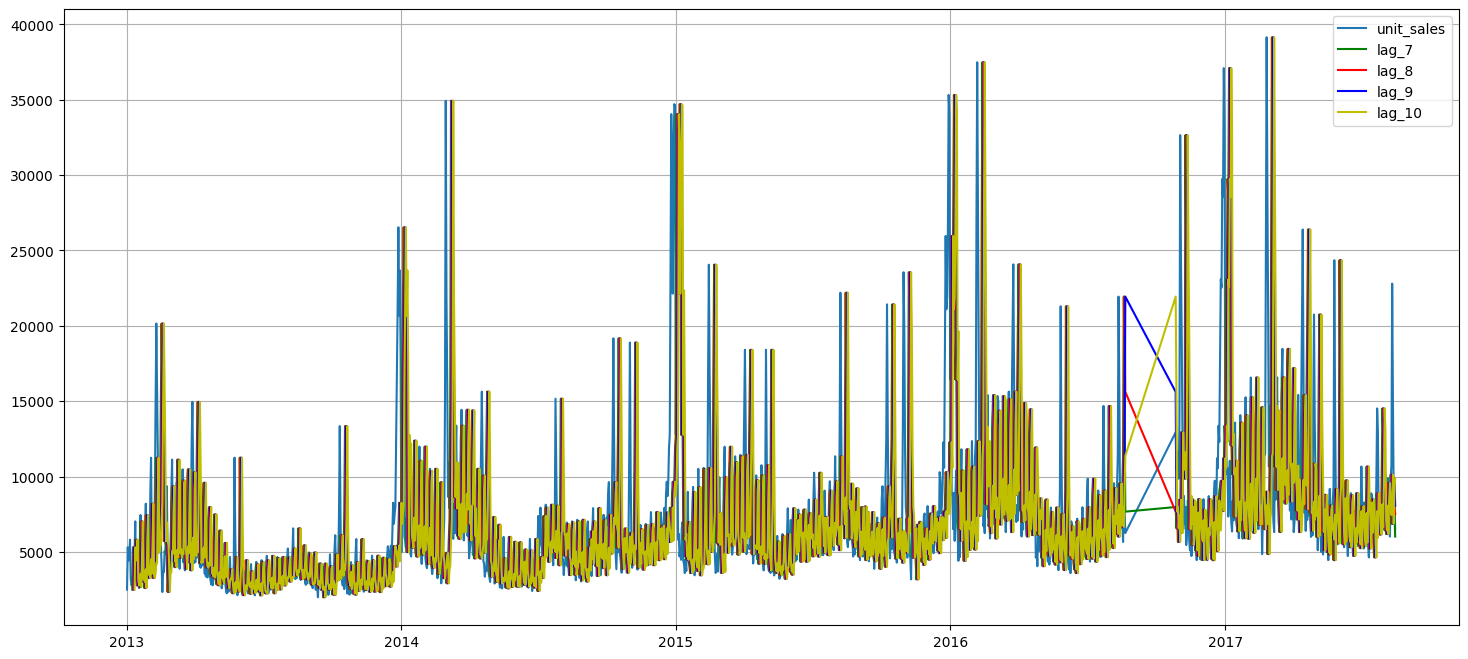

In [27]:
#Находим лаги с 7 по 10 и строим по ним график
for i in range(7,11):
    new_df2['lag_{}'.format(i)] = new_df2.unit_sales.shift(i)


## визуализируем
f, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(new_df2.index, new_df2.unit_sales) ## исходные данные
ax.plot(new_df2.index, new_df2['lag_' + str(7)],  c='g') 
ax.plot(new_df2.index, new_df2['lag_' + str(8)],  c='r') 
ax.plot(new_df2.index, new_df2['lag_' + str(9)],  c='b') 
ax.plot(new_df2.index, new_df2['lag_' + str(10)],  c='y') 
ax.legend(['unit_sales', 'lag_7', 'lag_8', 'lag_9', 'lag_10'])
ax.grid()

In [28]:
train = timedata.copy()
top1 = train[train.item_nbr == 103501 ]#продукт с номером 103501 (item_nbr) и приводим данные к виду временного ряда с группировкой по дате и агрегацией
top1['date'] = pd.to_datetime(top1['date'])
top1['year'] = top1['date'].dt.year
unit_sales_by_date = top1.groupby('date').sum()['unit_sales']

C:\Users\Алексей\AppData\Local\Temp\ipykernel_6072\3188691056.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top1['date'] = pd.to_datetime(top1['date'])
C:\Users\Алексей\AppData\Local\Temp\ipykernel_6072\3188691056.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top1['year'] = top1['date'].dt.year


In [29]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller

X = unit_sales_by_date
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Отклоняется Ho - Временной ряд стационарен")
else:
    print ("Не отклоняется Ho - Временной ряд не стационарен")

ADF Statistic: -4.154403
p-value: 0.000786
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Отклоняется Ho - Временной ряд стационарен


(6,) (6,)
mean_squared_error 287.087962962963
mean_absolute_error 13.416666666666666
mean_absolute_percentage_error 0.17213844967435177


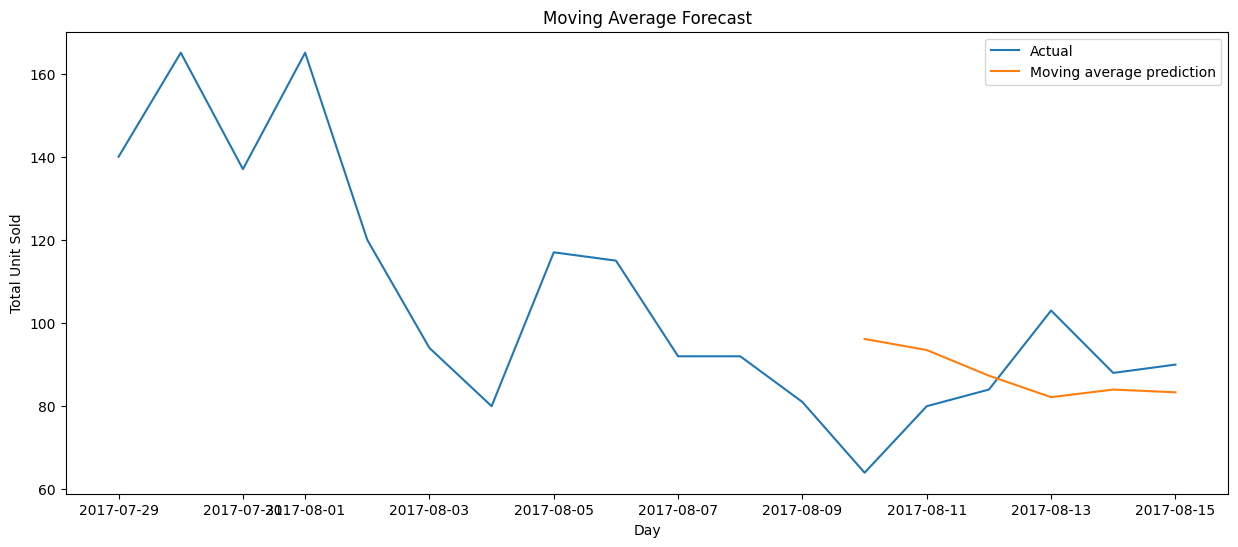

In [30]:
#рогноз методом скользящего среднего с окном 6 и метрики MSE, MAE, MAPE
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)
moving_average_days = 6

shown_train_size = moving_average_days * 3
moving_avg = moving_average_forecast(unit_sales_by_date,moving_average_days )
moving_avg = pd.Series(moving_avg, index = unit_sales_by_date[moving_average_days:].index)

print(moving_avg[-moving_average_days:].shape,unit_sales_by_date[-moving_average_days:].shape)

print("mean_squared_error",mean_squared_error(unit_sales_by_date.values[-moving_average_days:], moving_avg[-moving_average_days:]))
print("mean_absolute_error",mean_absolute_error(unit_sales_by_date.values[-moving_average_days:], moving_avg[-moving_average_days:]))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(unit_sales_by_date.values[-moving_average_days:], moving_avg[-moving_average_days:]))
plt.figure(figsize=(15,6))

plt.plot(unit_sales_by_date[- shown_train_size:], label="Actual")
plt.plot(moving_avg[-moving_average_days:], label="Moving average prediction")
plt.ylabel("Total Unit Sold")
plt.xlabel("Day")
plt.title("Moving Average Forecast")
plt.legend(loc="upper right")

[ 0.64650132 -0.09509512 -0.00478076 -0.00138304 -0.07253827  0.31681439]
21.24212700533488
mean_squared_error 107.89016173811997
mean_absolute_error 7.8986932308730715
mean_absolute_percentage_error 0.08961226340234724


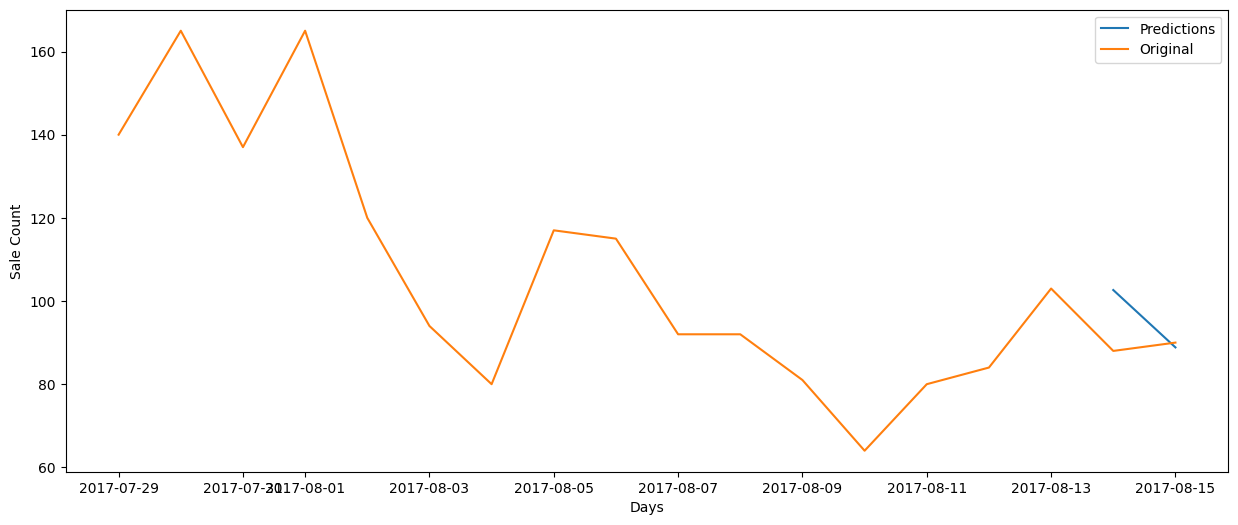

In [31]:
predict_size = 2# откладываем данные в тестовую выборку для предсказаний
df = pd.DataFrame()

df["Original Values"]  = unit_sales_by_date #Лаги с 1 по 6
df["shift1"] = df["Original Values"].shift()
df["shift2"] = df["shift1"].shift()
df["shift3"] = df["shift2"].shift()
df["shift4"] = df["shift3"].shift()
df["shift5"] = df["shift4"].shift()
df["shift6"] = df["shift5"].shift()
df.dropna(inplace=True)

x_train, y_train = df[:-predict_size].drop(["Original Values"], axis =1), df[:-predict_size]["Original Values"]
x_test, y_test  = df[-predict_size:].drop(["Original Values"], axis =1), df[-predict_size:]["Original Values"]


from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train, y_train)
print(reg.coef_)
print(reg.intercept_)


ar_predictions = pd.Series(reg.predict(x_test), index=x_test.index)

plt.figure(figsize=(15,6))
plt.plot(ar_predictions ,label = "Predictions")
plt.plot(pd.concat([y_train, y_test], axis = 0)[-shown_train_size:], label = "Original" )
plt.xlabel("Days")
plt.ylabel("Sale Count")

print("mean_squared_error",mean_squared_error(y_test, ar_predictions))
print("mean_absolute_error",mean_absolute_error(y_test, ar_predictions))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, ar_predictions))

plt.legend(loc="upper right")

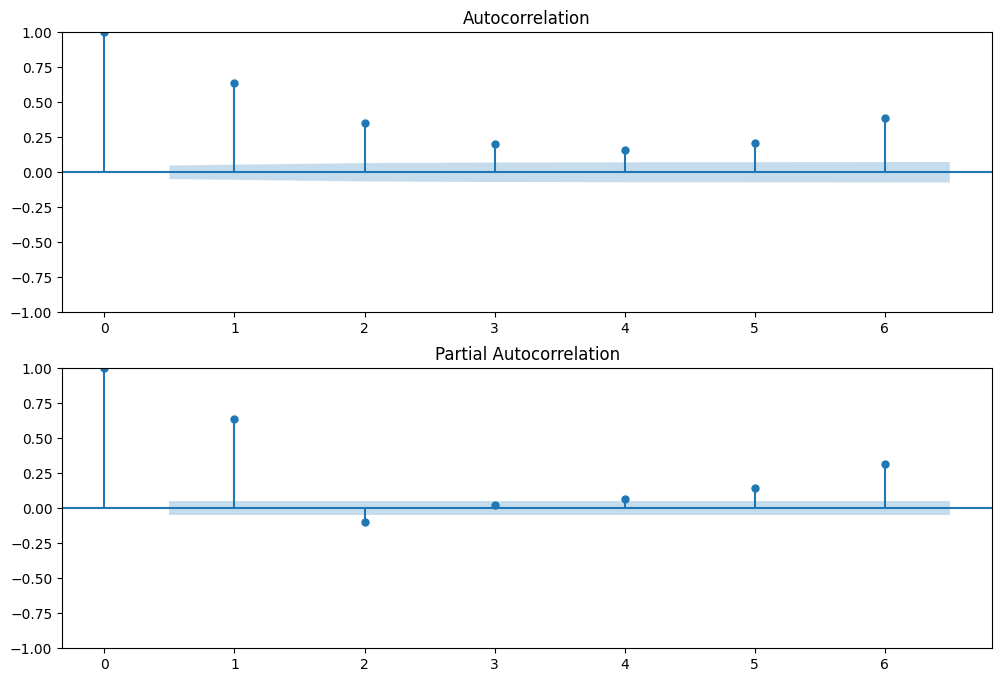

In [32]:
import statsmodels.api as sm
#Определяем p и q для модели
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(unit_sales_by_date.values.squeeze(), lags=6, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(unit_sales_by_date, lags=6, ax=ax2)

C:\Users\Алексей\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Алексей\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Алексей\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed t

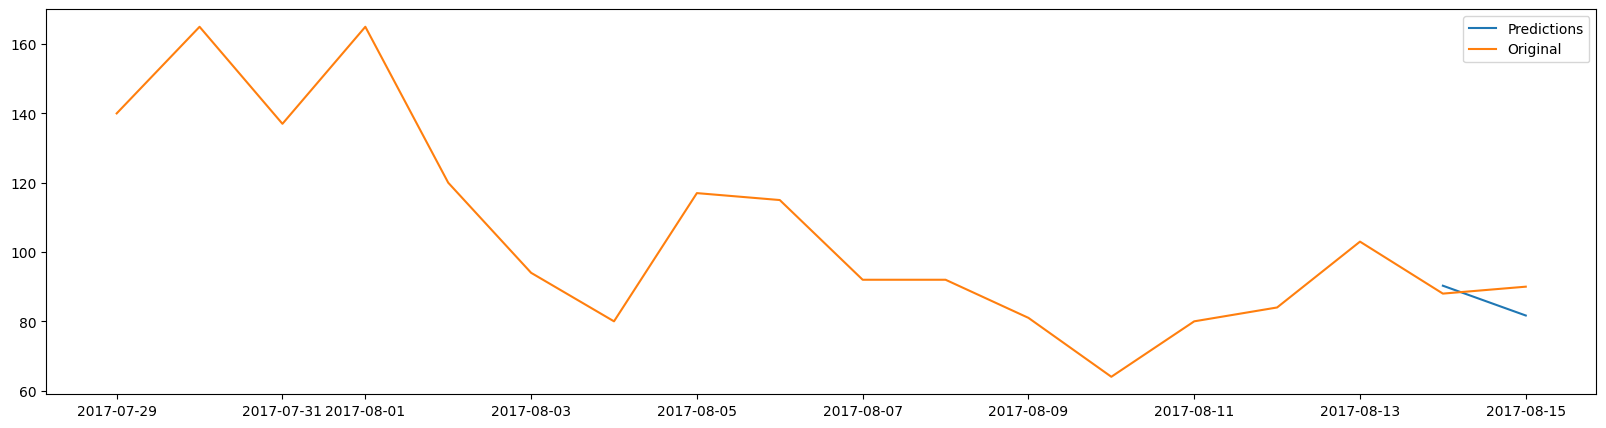

In [33]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(y_train.values.reshape(-1), order=(6,0,6))
from statsmodels.graphics.tsaplots import plot_predict

train_size = len(y_train)
test_size = predict_size
arima_predictions = model.fit().predict(start=train_size,end=train_size+test_size -1,  dynamic=False)
plt.rcParams["figure.figsize"] = [20, 5]
plt.plot(pd.Series(arima_predictions, index=y_test.index) ,label = "Predictions")
plt.plot(pd.concat([y_train, y_test], axis = 0)[-shown_train_size:], label = "Original" )
plt.legend(loc="upper right")

In [34]:
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, arima_predictions))
print("mean_squared_error",mean_squared_error(y_test, arima_predictions))
print("mean_absolute_error",mean_absolute_error(y_test, arima_predictions))

mean_absolute_percentage_error 0.059165563186981074
mean_squared_error 37.200588809757285
mean_absolute_error 5.29900430689257


*Вывод:Точность метрик лучше всех показала модель авторегрессии ARIMA*

In [35]:
# Load libraries

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 70)
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode()

from prophet import Prophet

In [36]:

df_new = timedata.groupby("date")['unit_sales'].sum().reset_index()
df_new.info()
df_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684 entries, 0 to 1683
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1684 non-null   object 
 1   unit_sales  1684 non-null   float64
dtypes: float64(1), object(1)
memory usage: 26.4+ KB


date  unit_sales
0  2013-01-01    2511.619
1  2013-01-02  496092.418
2  2013-01-03  361429.231
3  2013-01-04  354459.677
4  2013-01-05  477350.121

In [37]:
py.iplot([go.Scatter(
    x=df_new.date,
    y=df_new.unit_sales
)])

#### Видно небольшое влияние сезонности особенно перед новым годом

In [38]:
df_new.columns = ['ds', 'y']

In [39]:
m = Prophet()
m.fit(df_new)
future = m.make_future_dataframe(periods=365)#Делаем предсказания библиотекой профит на год вперед
forecast = m.predict(future)
forecast

12:19:43 - cmdstanpy - INFO - Chain [1] start processing
12:19:44 - cmdstanpy - INFO - Chain [1] done processing


ds          trend     yhat_lower    yhat_upper    trend_lower   
0    2013-01-01  334339.557973  230912.129359  5.024788e+05  334339.557973  \
1    2013-01-02  334709.425078  249405.578298  5.407228e+05  334709.425078   
2    2013-01-03  335079.292184  153980.654326  4.241220e+05  335079.292184   
3    2013-01-04  335449.159289  217145.246072  4.992353e+05  335449.159289   
4    2013-01-05  335819.026395  399099.682687  6.676989e+05  335819.026395   
...         ...            ...            ...           ...            ...   
2044 2018-08-11  992940.440847  904536.884748  1.190213e+06  947723.061337   
2045 2018-08-12  993209.047680  968575.089521  1.259386e+06  947820.511330   
2046 2018-08-13  993477.654513  749197.580400  1.054372e+06  947917.961324   
2047 2018-08-14  993746.261346  708338.280628  1.006124e+06  948015.411318   
2048 2018-08-15  994014.868180  734350.762165  1.011840e+06  948112.861311   

       trend_upper  additive_terms  additive_terms_lower   
0     3.343396e+05    43479.595164          43479.595164  \
1     3.347094e+05    55521.983079          55521.983079   
2     3.350793e+05   -44091.993238         -44091.993238   
3     3.354492e+05    18980.476919          18980.476919   
4     3.358190e+05   198563.733324         198563.733324   
...            ...             ...                   ...   
2044  1.040577e+06    62507.821270          62507.821270   
2045  1.041040e+06   116406.034755         116406.034755   
2046  1.041500e+06   -92974.081792         -92974.081792   
2047  1.041922e+06  -139173.462331        -139173.462331   
2048  1.042336e+06  -113751.597821        -113751.597821   

      additive_terms_upper         weekly   weekly_lower   weekly_upper   
0             43479.595164  -68157.942659  -68157.942659  -68157.942659  \
1             55521.983079  -44199.968067  -44199.968067  -44199.968067   
2            -44091.993238 -131878.686822 -131878.686822 -131878.686822   
3             18980.476919  -57029.549952  -57029.549952  -57029.549952   
4            198563.733324  134003.618265  134003.618265  134003.618265   
...                    ...            ...            ...            ...   
2044          62507.821270  134003.618264  134003.618264  134003.618264   
2045         116406.034755  188401.650111  188401.650111  188401.650111   
2046         -92974.081792  -21139.120876  -21139.120876  -21139.120876   
2047        -139173.462331  -68157.942659  -68157.942659  -68157.942659   
2048        -113751.597821  -44199.968067  -44199.968067  -44199.968067   

             yearly   yearly_lower   yearly_upper  multiplicative_terms   
0     111637.537823  111637.537823  111637.537823                   0.0  \
1      99721.951145   99721.951145   99721.951145                   0.0   
2      87786.693584   87786.693584   87786.693584                   0.0   
3      76010.026870   76010.026870   76010.026870                   0.0   
4      64560.115060   64560.115060   64560.115060                   0.0   
...             ...            ...            ...                   ...   
2044  -71495.796994  -71495.796994  -71495.796994                   0.0   
2045  -71995.615356  -71995.615356  -71995.615356                   0.0   
2046  -71834.960916  -71834.960916  -71834.960916                   0.0   
2047  -71015.519672  -71015.519672  -71015.519672                   0.0   
2048  -69551.629755  -69551.629755  -69551.629755                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                            0.0                         0.0  3.778192e+05  
1                            0.0                         0.0  3.902314e+05  
2                            0.0                         0.0  2.909873e+05  
3                            0.0                         0.0  3.544296e+05  
4                            0.0                         0.0  5.343828e+05  
...                          ...                         ...           ...  
2044          

In [40]:
py.iplot([
    go.Scatter(x=df_new['ds'], y=df_new['y'], name='y'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')
])

In [41]:
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:1684, 'yhat']-df_new['y'])**2)) )

RMSE: 107792.799979


In [42]:
m = Prophet(changepoint_prior_scale=0.15)
m.fit(df_new)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

12:19:45 - cmdstanpy - INFO - Chain [1] start processing
12:19:46 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
# Вычислим среднеквадратичную ошибку.
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:1684, 'yhat']-df_new['y'])**2)) )
py.iplot([
    go.Scatter(x=df_new['ds'], y=df_new['y'], name='y'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')
])

RMSE: 102219.182860


#### Коэффициент надо сдвигать вниз к меньшему значению в противном случае тренд недообучиться но не меньше 0.15 а то переобучиться.Метрики выросли

In [44]:
m = Prophet(changepoint_prior_scale=0.15)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(df_new)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

12:19:47 - cmdstanpy - INFO - Chain [1] start processing
12:19:48 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
# Вычислим среднеквадратичную ошибку.
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:1684, 'yhat']-df_new['y'])**2)) )
py.iplot([
    go.Scatter(x=df_new['ds'], y=df_new['y'], name='y'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')
])

RMSE: 95488.116539


#### Модель улучшилась метрика стала лучше

In [46]:
df_holidays_events = pd.read_csv('timedata/holidays_events.csv')

In [47]:
holidays = df_holidays_events[df_holidays_events['transferred'] == False][['description', 'date']]
holidays.columns = ['holiday', 'ds']
#holidays['lower_window'] = 0
#holidays['upper_window'] = 0
holidays

holiday          ds
0               Fundacion de Manta  2012-03-02
1    Provincializacion de Cotopaxi  2012-04-01
2              Fundacion de Cuenca  2012-04-12
3        Cantonizacion de Libertad  2012-04-14
4        Cantonizacion de Riobamba  2012-04-21
..                             ...         ...
345                      Navidad-3  2017-12-22
346                      Navidad-2  2017-12-23
347                      Navidad-1  2017-12-24
348                        Navidad  2017-12-25
349                      Navidad+1  2017-12-26

[338 rows x 2 columns]

In [48]:
m = Prophet(changepoint_prior_scale=0.15, holidays=holidays)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(df_new)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

12:19:49 - cmdstanpy - INFO - Chain [1] start processing
12:19:50 - cmdstanpy - INFO - Chain [1] done processing


In [49]:
# Вычислим среднеквадратичную ошибку.
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:1684, 'yhat']-df_new['y'])**2)) )
py.iplot([
    go.Scatter(x=df_new['ds'], y=df_new['y'], name='y'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')
])

RMSE: 77080.560584


## Вывод: чем больше дополнительно работать с моделью fbprophet тем можно более усовершенствовать ее и тем лучше будет инференс

In [50]:
timedata = timedata.groupby("date")['unit_sales'].sum().reset_index()

In [51]:
new_df = timedata.set_index(pd.DatetimeIndex(timedata['date'])) 
new_df.drop(['date'], axis = 1, inplace = True)
new_df

unit_sales
date                  
2013-01-01    2511.619
2013-01-02  496092.418
2013-01-03  361429.231
2013-01-04  354459.677
2013-01-05  477350.121
...                ...
2017-08-11  826373.722
2017-08-12  792630.535
2017-08-13  865639.677
2017-08-14  760922.406
2017-08-15  762661.936

[1684 rows x 1 columns]

In [52]:
split_date = '01-Jan-2017'
X_train1 = new_df.loc[new_df.index <= split_date].copy()
X_test1 = new_df.loc[new_df.index > split_date].copy()


In [53]:
def create_features(df, label=None):
    """
    создаем признаки из datetime индекса
    """
    df['date'] = df.index
    
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [54]:
X_train, y_train = create_features(X_train1, label='unit_sales')
X_test, y_test = create_features(X_test1, label='unit_sales')

In [55]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=100)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False) # Измените verbose на True, если хотите увидеть процесс обучения

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

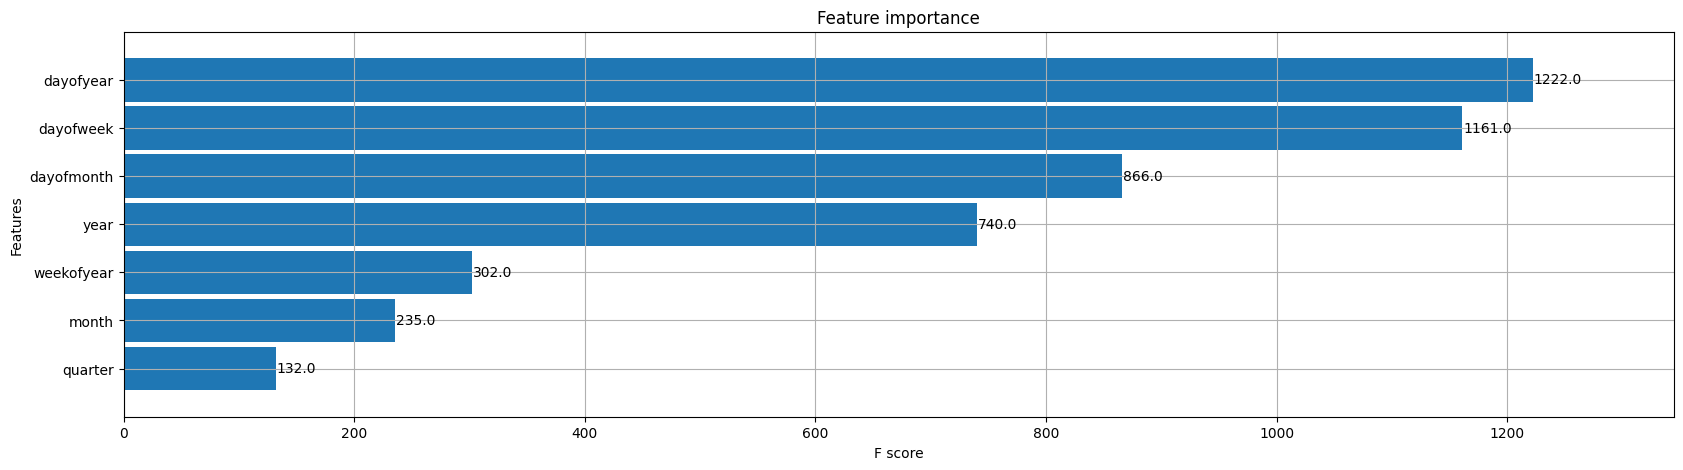

In [56]:
_ = plot_importance(reg, height=0.9)

In [57]:
cbr = CatBoostRegressor(n_estimators=1000)
cbr.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=100,
       verbose=False)

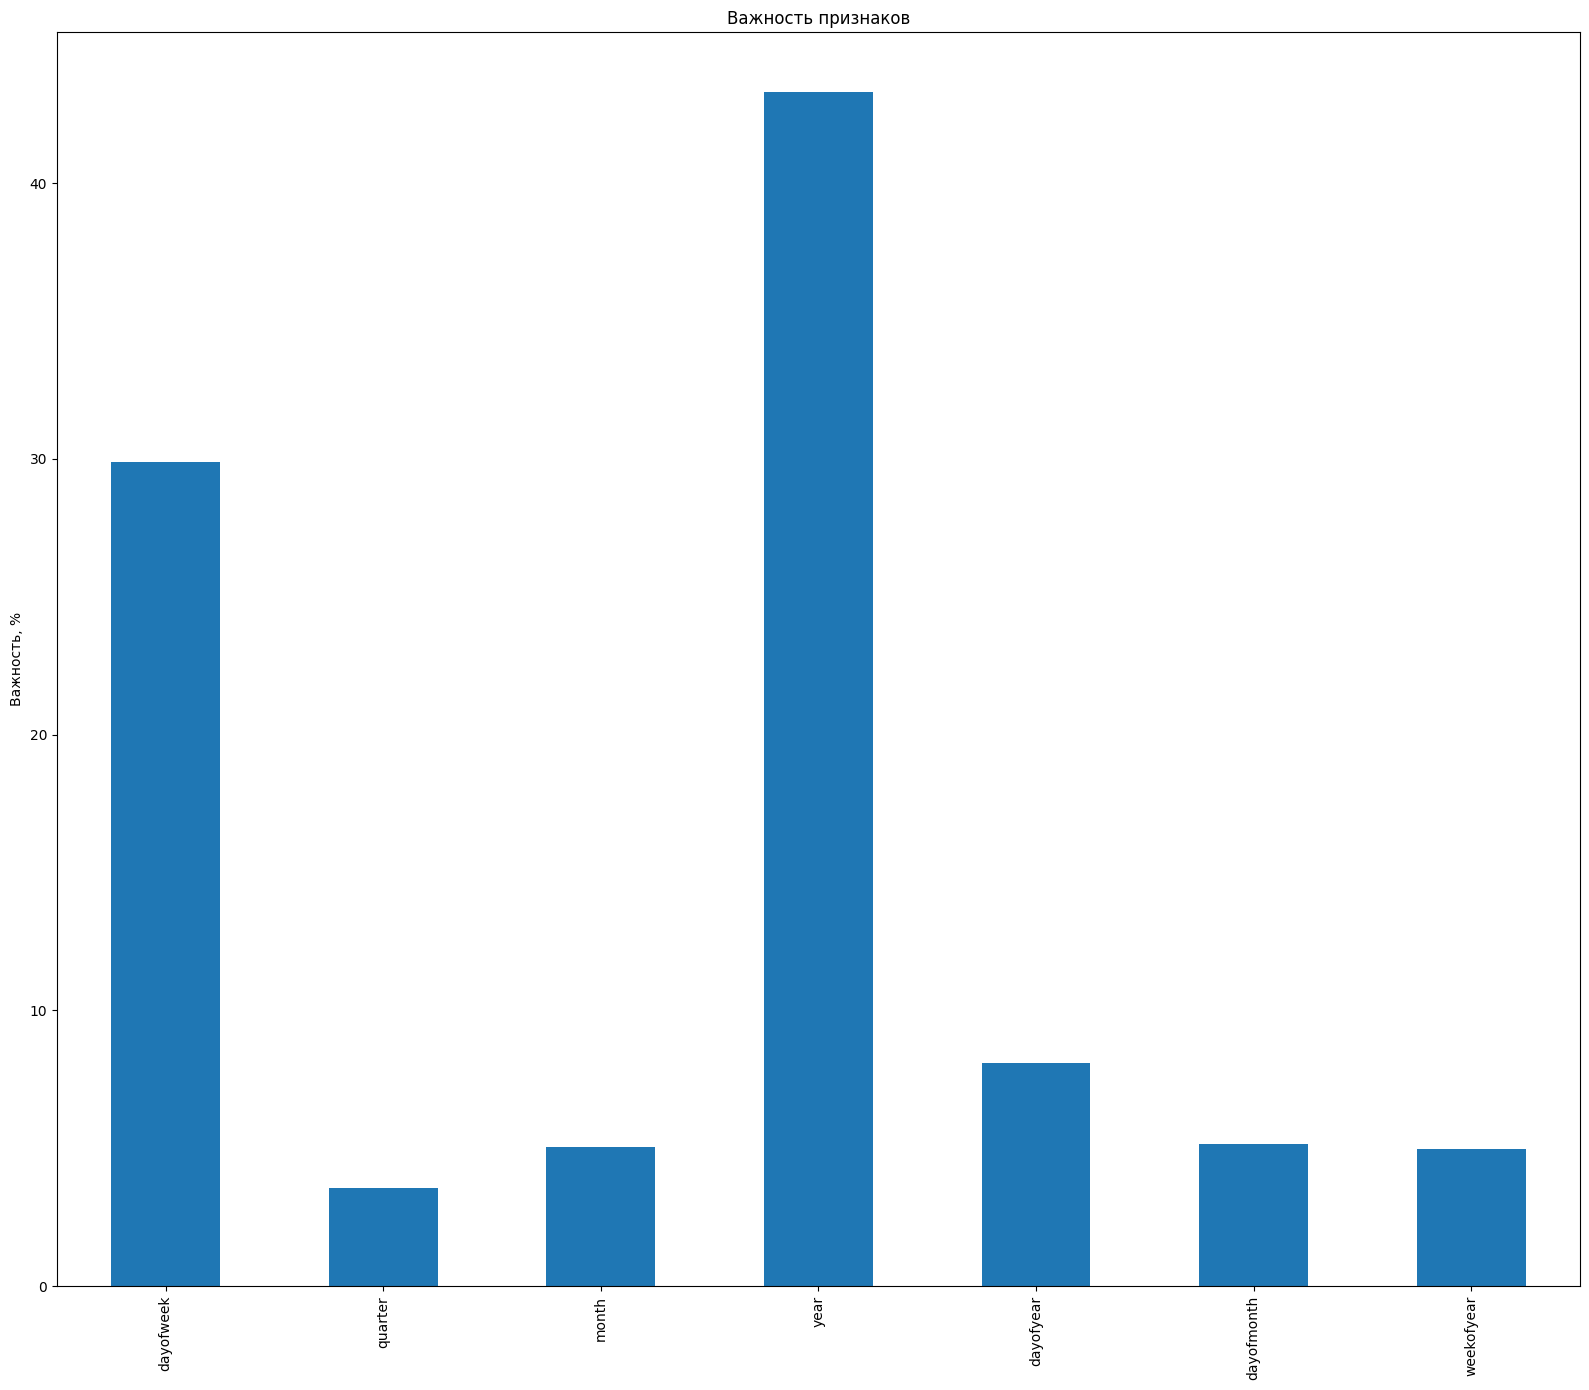

In [58]:
cat_iris_imp = pd.Series(cbr.get_feature_importance(),
                         X_train.columns)
fig, ax = plt.subplots(figsize=(16,14))
cat_iris_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

#### Вывод:Обе модели посчитали разные признаки более важными но факт что признаки связаные с годом или с днем в году самые влиятельные на делении деревьев в обеих моделях.Еще один важный признак для обеих моделей это день недели

In [59]:
X_test1['Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([X_test1, X_train1], sort=False)

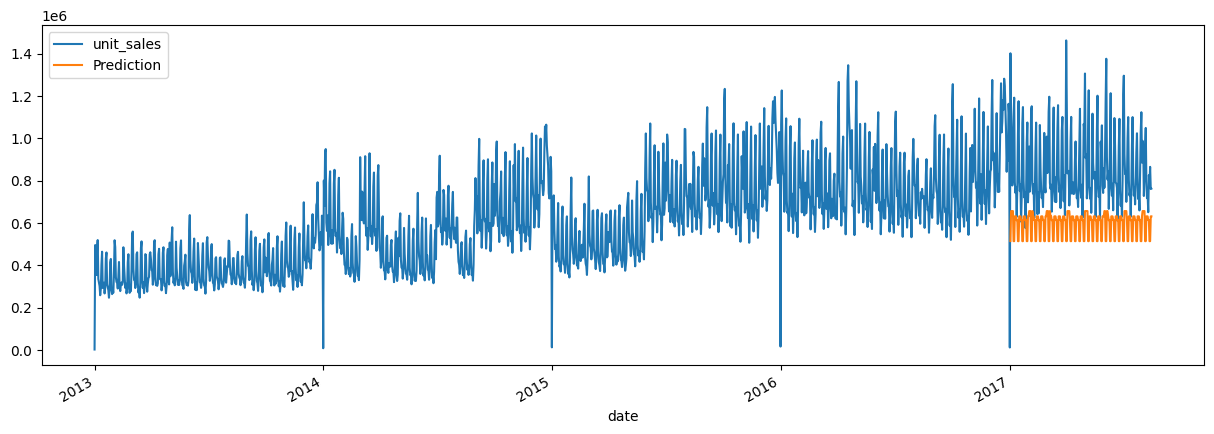

In [60]:
_ = pjme_all[['unit_sales','Prediction']].plot(figsize=(15, 5))

In [61]:
X_test1['Prediction'] = cbr.predict(X_test)
pjme_all = pd.concat([X_test1, X_train1], sort=False)

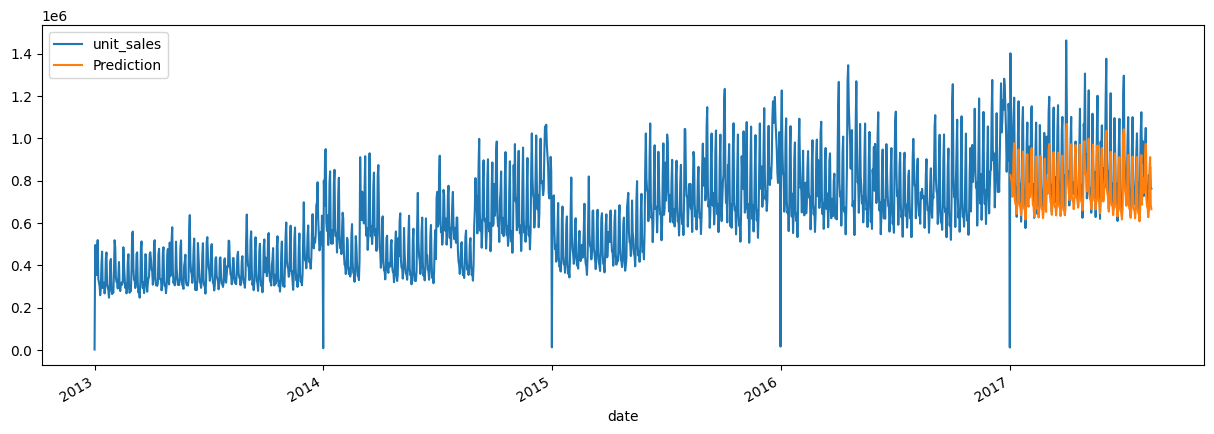

In [62]:
_ = pjme_all[['unit_sales','Prediction']].plot(figsize=(15, 5))

#### Вывод:Признаки отобранные и сама модель Catboost делает более точные предсказания 

In [63]:
reg_predict = reg.predict(X_test)


print("mean_squared_error",mean_squared_error(y_test, reg_predict))
print("mean_absolute_error",mean_absolute_error(y_test, reg_predict))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, reg_predict))

mean_squared_error 113854100254.7705
mean_absolute_error 262051.0728340708
mean_absolute_percentage_error 0.2723398573826363


In [64]:
reg_predict = cbr.predict(X_test)


print("mean_squared_error",mean_squared_error(y_test, reg_predict))
print("mean_absolute_error",mean_absolute_error(y_test, reg_predict))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, reg_predict))

mean_squared_error 17018160492.4127
mean_absolute_error 103095.1806365714
mean_absolute_percentage_error 0.11115202498326487


In [65]:
X_test1 = X_test1.drop(['Prediction'], axis=1)
X_test1

unit_sales       date  dayofweek  quarter  month  year   
date                                                                  
2017-01-02  1402305.371 2017-01-02          0        1      1  2017  \
2017-01-03  1104377.080 2017-01-03          1        1      1  2017   
2017-01-04   990093.463 2017-01-04          2        1      1  2017   
2017-01-05   777620.954 2017-01-05          3        1      1  2017   
2017-01-06   839600.238 2017-01-06          4        1      1  2017   
...                 ...        ...        ...      ...    ...   ...   
2017-08-11   826373.722 2017-08-11          4        3      8  2017   
2017-08-12   792630.535 2017-08-12          5        3      8  2017   
2017-08-13   865639.677 2017-08-13          6        3      8  2017   
2017-08-14   760922.406 2017-08-14          0        3      8  2017   
2017-08-15   762661.936 2017-08-15          1        3      8  2017   

            dayofyear  dayofmonth  weekofyear  
date                                           
2017-01-02          2           2           1  
2017-01-03          3           3           1  
2017-01-04          4           4           1  
2017-01-05          5           5           1  
2017-01-06          6           6           1  
...               ...         ...         ...  
2017-08-11        223          11          32  
2017-08-12        224          12          32  
2017-08-13        225          13          32  
2017-08-14        226          14          33  
2017-08-15        227          15          33  

[226 rows x 9 columns]

In [66]:
import holidays#Добавляю данные о праздничных днях
def is_holiday(row):
    us_holidays = holidays.country_holidays('Russia') 
    return int(row['date'] in us_holidays)
X_train1['is_holiday'] = X_train1.apply(is_holiday, axis=1)
X_test1['is_holiday'] = X_test1.apply(is_holiday, axis=1)
X_train1

unit_sales       date  dayofweek  quarter  month  year   
date                                                                  
2013-01-01     2511.619 2013-01-01          1        1      1  2013  \
2013-01-02   496092.418 2013-01-02          2        1      1  2013   
2013-01-03   361429.231 2013-01-03          3        1      1  2013   
2013-01-04   354459.677 2013-01-04          4        1      1  2013   
2013-01-05   477350.121 2013-01-05          5        1      1  2013   
...                 ...        ...        ...      ...    ...   ...   
2016-12-28   951533.714 2016-12-28          2        4     12  2016   
2016-12-29   894108.237 2016-12-29          3        4     12  2016   
2016-12-30  1163643.038 2016-12-30          4        4     12  2016   
2016-12-31  1109012.812 2016-12-31          5        4     12  2016   
2017-01-01    12082.501 2017-01-01          6        1      1  2017   

            dayofyear  dayofmonth  weekofyear  is_holiday  
date                                                       
2013-01-01          1           1           1           1  
2013-01-02          2           2           1           1  
2013-01-03          3           3           1           1  
2013-01-04          4           4           1           1  
2013-01-05          5           5           1           1  
...               ...         ...         ...         ...  
2016-12-28        363          28          52           0  
2016-12-29        364          29          52           0  
2016-12-30        365          30          52           0  
2016-12-31        366          31          52           0  
2017-01-01          1           1          52           1  

[1458 rows x 10 columns]

In [67]:
X_train = X_train1.drop(['unit_sales', 'date'], axis=1)
X_test = X_test1.drop(['unit_sales', 'date'], axis=1)
X_train

dayofweek  quarter  month  year  dayofyear  dayofmonth   
date                                                                 
2013-01-01          1        1      1  2013          1           1  \
2013-01-02          2        1      1  2013          2           2   
2013-01-03          3        1      1  2013          3           3   
2013-01-04          4        1      1  2013          4           4   
2013-01-05          5        1      1  2013          5           5   
...               ...      ...    ...   ...        ...         ...   
2016-12-28          2        4     12  2016        363          28   
2016-12-29          3        4     12  2016        364          29   
2016-12-30          4        4     12  2016        365          30   
2016-12-31          5        4     12  2016        366          31   
2017-01-01          6        1      1  2017          1           1   

            weekofyear  is_holiday  
date                                
2013-01-01           1           1  
2013-01-02           1           1  
2013-01-03           1           1  
2013-01-04           1           1  
2013-01-05           1           1  
...                ...         ...  
2016-12-28          52           0  
2016-12-29          52           0  
2016-12-30          52           0  
2016-12-31          52           0  
2017-01-01          52           1  

[1458 rows x 8 columns]

In [68]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=100)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [69]:
reg_predict = reg.predict(X_test)


print("mean_squared_error",mean_squared_error(y_test, reg_predict))
print("mean_absolute_error",mean_absolute_error(y_test, reg_predict))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, reg_predict))

mean_squared_error 113854100254.7705
mean_absolute_error 262051.0728340708
mean_absolute_percentage_error 0.2723398573826363


In [70]:
cbr = CatBoostRegressor(n_estimators=1000)
cbr.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=100,
       verbose=False)

In [71]:
reg_predict = cbr.predict(X_test)


print("mean_squared_error",mean_squared_error(y_test, reg_predict))
print("mean_absolute_error",mean_absolute_error(y_test, reg_predict))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, reg_predict))

mean_squared_error 20871732066.478302
mean_absolute_error 115350.11434234661
mean_absolute_percentage_error 0.12385851891992836


In [72]:
y_train1 = y_train.reset_index()
for i in range(1,20):
    y_train1['lag_{}'.format(i)] = y_train1.unit_sales.shift(i)



In [73]:
y_test1 = y_test.reset_index()
for i in range(1,20):
    y_test1['lag_{}'.format(i)] = y_test1.unit_sales.shift(i)

In [74]:
y_test1 = y_test1.fillna(0)
y_train1 = y_train1.fillna(0)

In [75]:
y_train1 = y_train1.set_index('date')
y_train1 = y_train1.drop(['unit_sales'], axis=1)

In [76]:
X_train = pd.concat([X_train, y_train1], axis=1)
X_train

dayofweek  quarter  month  year  dayofyear  dayofmonth   
date                                                                 
2013-01-01          1        1      1  2013          1           1  \
2013-01-02          2        1      1  2013          2           2   
2013-01-03          3        1      1  2013          3           3   
2013-01-04          4        1      1  2013          4           4   
2013-01-05          5        1      1  2013          5           5   
...               ...      ...    ...   ...        ...         ...   
2016-12-28          2        4     12  2016        363          28   
2016-12-29          3        4     12  2016        364          29   
2016-12-30          4        4     12  2016        365          30   
2016-12-31          5        4     12  2016        366          31   
2017-01-01          6        1      1  2017          1           1   

            weekofyear  is_holiday        lag_1        lag_2        lag_3   
date                                                                        
2013-01-01           1           1        0.000        0.000        0.000  \
2013-01-02           1           1     2511.619        0.000        0.000   
2013-01-03           1           1   496092.418     2511.619        0.000   
2013-01-04           1           1   361429.231   496092.418     2511.619   
2013-01-05           1           1   354459.677   361429.231   496092.418   
...                ...         ...          ...          ...          ...   
2016-12-28          52           0   842474.490  1032770.749  1246837.843   
2016-12-29          52           0   951533.714   842474.490  1032770.749   
2016-12-30          52           0   894108.237   951533.714   842474.490   
2016-12-31          52           0  1163643.038   894108.237   951533.714   
2017-01-01          52           1  1109012.812  1163643.038   894108.237   

                  lag_4        lag_5        lag_6        lag_7        lag_8   
date                                                                          
2013-01-01        0.000        0.000        0.000        0.000        0.000  \
2013-01-02        0.000        0.000        0.000        0.000        0.000   
2013-01-03        0.000        0.000        0.000        0.000        0.000   
2013-01-04        0.000        0.000        0.000        0.000        0.000   
2013-01-05     2511.619        0.000        0.000        0.000        0.000   
...                 ...          ...          ...          ...          ...   
2016-12-28  1282145.517  1135849.392  1181307.327  1078323.690  1028242.823   
2016-12-29  1246837.843  1282145.517  1135849.392  1181307.327  1078323.690   
2016-12-30  1032770.749  1246837.843  1282145.517  1135849.392  1181307.327   
2016-12-31   842474.490  1032770.749  1246837.843  1282145.517  1135849.392   
2017-01-01   951533.714   842474.490  1032770.749  1246837.843  1282145.517   

                  lag_9       lag_10       lag_11       lag_12       lag_13   
date                                                                          
2013-01-01        0.000        0.000        0.000        0.000        0.000  \
2013-01-02        0.000        0.000        0.000        0.000        0.000   
2013-01-03        0.000        0.000        0.000        0.000        0.000   
2013-01-04        0.000        0.000        0.000        0.000        0.000   
2013-01-05        0.000        0.000        0.000        0.000        0.000   
...                 ...          ...          ...          ...          ...   
2016-12-28  1260471.908  1071655.628   918899.786   747641.183   829762.219   
2016-12-29  1028242.823  1260471.908  1071655.628   918899.786   747641.183   
2016-12-30  1078323.690  1028242.823  1260471.908  1071655.628   918899.786   
2016-12-31  1181307.327  1078323.690  1028242.823  1260471.908  1071655.628   
2017-01-01  1135849.392  1181307.327  1078323.690  1028242.823  1260471.908   

                 lag_14      lag_15       l

In [77]:
y_test1 = y_test1.set_index('date')
y_test1 = y_test1.drop(['unit_sales'], axis=1)
X_test = pd.concat([X_test, y_test1], axis=1)
X_test

dayofweek  quarter  month  year  dayofyear  dayofmonth   
date                                                                 
2017-01-02          0        1      1  2017          2           2  \
2017-01-03          1        1      1  2017          3           3   
2017-01-04          2        1      1  2017          4           4   
2017-01-05          3        1      1  2017          5           5   
2017-01-06          4        1      1  2017          6           6   
...               ...      ...    ...   ...        ...         ...   
2017-08-11          4        3      8  2017        223          11   
2017-08-12          5        3      8  2017        224          12   
2017-08-13          6        3      8  2017        225          13   
2017-08-14          0        3      8  2017        226          14   
2017-08-15          1        3      8  2017        227          15   

            weekofyear  is_holiday        lag_1        lag_2        lag_3   
date                                                                        
2017-01-02           1           1        0.000        0.000        0.000  \
2017-01-03           1           1  1402305.371        0.000        0.000   
2017-01-04           1           1  1104377.080  1402305.371        0.000   
2017-01-05           1           1   990093.463  1104377.080  1402305.371   
2017-01-06           1           1   777620.954   990093.463  1104377.080   
...                ...         ...          ...          ...          ...   
2017-08-11          32           0   651386.912   734139.674   717766.349   
2017-08-12          32           0   826373.722   651386.912   734139.674   
2017-08-13          32           0   792630.535   826373.722   651386.912   
2017-08-14          33           0   865639.677   792630.535   826373.722   
2017-08-15          33           0   760922.406   865639.677   792630.535   

                  lag_4        lag_5        lag_6        lag_7        lag_8   
date                                                                          
2017-01-02        0.000        0.000        0.000        0.000        0.000  \
2017-01-03        0.000        0.000        0.000        0.000        0.000   
2017-01-04        0.000        0.000        0.000        0.000        0.000   
2017-01-05        0.000        0.000        0.000        0.000        0.000   
2017-01-06  1402305.371        0.000        0.000        0.000        0.000   
...                 ...          ...          ...          ...          ...   
2017-08-11   797464.964  1049559.164   965693.650   827775.686   728068.485   
2017-08-12   717766.349   797464.964  1049559.164   965693.650   827775.686   
2017-08-13   734139.674   717766.349   797464.964  1049559.164   965693.650   
2017-08-14   651386.912   734139.674   717766.349   797464.964  1049559.164   
2017-08-15   826373.722   651386.912   734139.674   717766.349   797464.964   

                  lag_9      lag_10      lag_11       lag_12       lag_13   
date                                                                        
2017-01-02        0.000       0.000       0.000        0.000        0.000  \
2017-01-03        0.000       0.000       0.000        0.000        0.000   
2017-01-04        0.000       0.000       0.000        0.000        0.000   
2017-01-05        0.000       0.000       0.000        0.000        0.000   
2017-01-06        0.000       0.000       0.000        0.000        0.000   
...                 ...         ...         ...          ...          ...   
2017-08-11   964712.016  988527.763  885856.841  1123752.478  1032310.866   
2017-08-12   728068.485  964712.016  988527.763   885856.841  1123752.478   
2017-08-13   827775.686  728068.485  964712.016   988527.763   885856.841   
2017-08-14   965693.650  827775.686  728068.485   964712.016   988527.763   
2017-08-15  1049559.164  965693.650  827775.686   728068.485   964712.016   

                 lag_14       lag_15       lag_16       lag_17      l

In [78]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=100)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [79]:
cbr = CatBoostRegressor(n_estimators=1000)
cbr.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=100,
       verbose=False)

In [80]:
cbr_predict = cbr.predict(X_test)


print("mean_squared_error",mean_squared_error(y_test, cbr_predict))
print("mean_absolute_error",mean_absolute_error(y_test, cbr_predict))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, cbr_predict))

mean_squared_error 13763847157.890305
mean_absolute_error 71574.49736253773
mean_absolute_percentage_error 0.07672382652967367


In [81]:
reg_predict = reg.predict(X_test)


print("mean_squared_error",mean_squared_error(y_test, reg_predict))
print("mean_absolute_error",mean_absolute_error(y_test, reg_predict))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, reg_predict))

mean_squared_error 66979003611.83329
mean_absolute_error 159781.34309513273
mean_absolute_percentage_error 0.159270867892039


### Вывод по моделям что чем больше столбцов качественных данных добавлять тем лучше оценка метрик этих моделей 